In [3]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices, SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)

In [29]:
n_corr = 20
corrs = np.linspace(-0.999, 0.999, n_corr)

No = 1000
Ni = 100
Nv = 10000

max_budget = Nv + No * Ni * np.math.factorial(dim) * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'sobolmara'
n_boot = 500

Max budget: 1210000


In [30]:
use_meta_model = False
n_realization = 1
if use_meta_model:
    ot.RandomGenerator.SetSeed(0)
    np.random.seed(0)
    model_budget = 300
    n_realization = 1
    basis = 'quadratic'
    kernel = 'matern'
    library = 'sklearn'
    sampling = 'lhs'
    shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
    meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                                 sampling=sampling)
    
    n_sample_cv = 10000
    score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
    print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

In [31]:
%%time
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

for corr in corrs:
    print('Corr:', corr)
    theta = [0., corr, 0.]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)

    #Sobol Full and Ind
    if use_meta_model:
        sobol = SobolKrigingIndices(meta_model.input_distribution)
        sobol.build_uncorrelated_mc_sample(meta_model.predict, n_sample, n_realization=n_realization)
    else:
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorrelated_mc_sample(model, n_sample)
        
    sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    
    # Shapley
    if use_meta_model:
        shapley = ShapleyKrigingIndices(meta_model.input_distribution)
        shapley.build_mc_sample(model=meta_model.predict, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)
    else:
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
    
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())

Corr: -0.999
Corr: -0.893842105263
Corr: -0.788684210526
Corr: -0.683526315789
Corr: -0.578368421053
Corr: -0.473210526316
Corr: -0.368052631579
Corr: -0.262894736842
Corr: -0.157736842105
Corr: -0.0525789473684
Corr: 0.0525789473684
Corr: 0.157736842105
Corr: 0.262894736842
Corr: 0.368052631579
Corr: 0.473210526316
Corr: 0.578368421053
Corr: 0.683526315789
Corr: 0.788684210526
Corr: 0.893842105263
Corr: 0.999
Wall time: 15min 22s


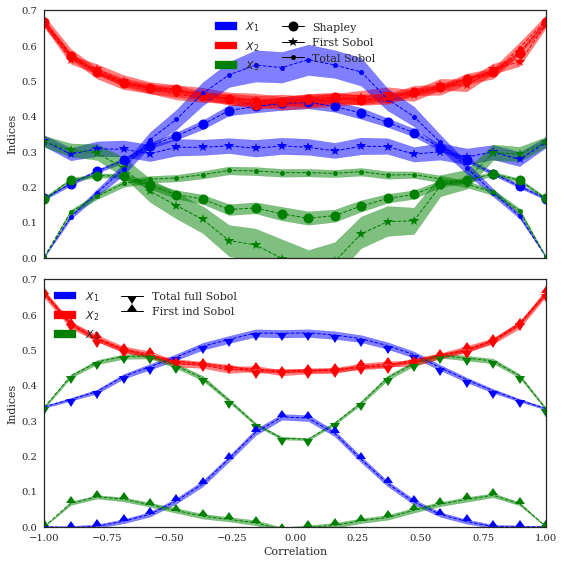

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

ax = axes[0]
to_plot = ['Shapley', 'First Sobol', 'Total Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_xlabel('')
ax.set_ylim(0., 0.7)

ax = axes[1]
to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')

ax.set_ylim(0., 0.7)
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_both_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

In [33]:
n_sample

100833

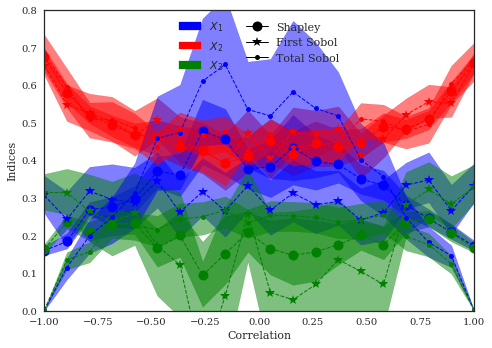

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

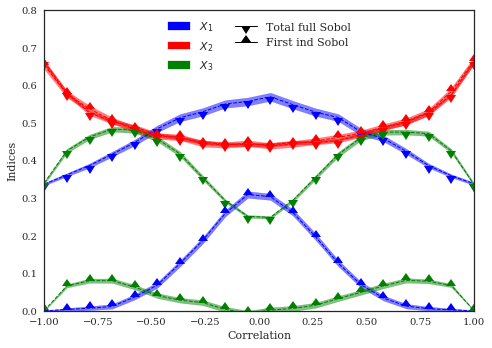

In [76]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()